# TERILS MOSDAC RADAR
- @author: syed44@purdue.edu
- @date: Nov 1, 2022
---

### Note
The issue with the data is that it doesn't have sweep start ray index and sweep end ray index. We will try to add these things manually. Also it has issues with timestamp as well. We will try to take care of that as well. Remember to make a backup of the original data, as I will try to rewrite it.

In [2]:
import xarray as xr
import pyart
import numpy as np
import pyscancf as pcf
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter, FuncFormatter
import pandas as pd
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
import glob

In [3]:
files = sorted(glob.glob("RCT*.nc"))
len(files)

2

In [4]:
for file in files:
#     print(file.split("_")[1:3])
    time_str = pd.to_datetime(file.split("_")[1:3][0]+" "+file.split("_")[1:3][1])
#     print(time_str)
    radar = pyart.io.read(file)
    radar.time['units'] = "seconds since "+time_str.to_datetime64().astype(str)[:-7]
    radar.sweep_start_ray_index['data'] = np.arange(0,
                                                radar.azimuth['data'].size,
                                                radar.azimuth['data'].size//radar.sweep_number['data'].size)

    radar.sweep_end_ray_index['data'] = np.arange(radar.azimuth['data'].size//radar.sweep_number['data'].size-1,
              radar.azimuth['data'].size,
              radar.azimuth['data'].size//radar.sweep_number['data'].size)
    pyart.io.write_cfradial(file, radar)

### Watch carefully:
We have rewrote the data with the timestamps and ray indices, now we can normally use these files in any package e.g., wradlib, pyart etc.

In [4]:
radar = pyart.io.read("RCTLS_12OCT2022_103335_L2B_STD.nc")

In [5]:
display = pyart.graph.RadarDisplay(radar)

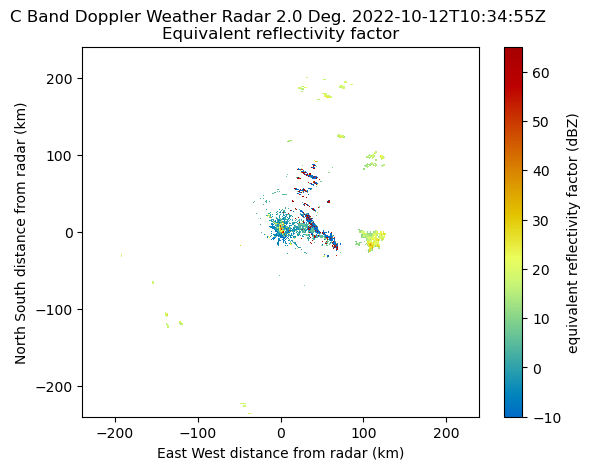

In [6]:
display.plot("DBZ", 2)

In [18]:
import pyscancf as pcf
grid = pcf.get_grid(radar, grid_shape=(200, 500, 500), height=15, length=200)

In [19]:
xgrid = grid.to_xarray()

In [20]:
grid.fields['REF'] = grid.fields['DBZ']

Generating Figures of Max-CAPPI, please be patient!
Figures saved


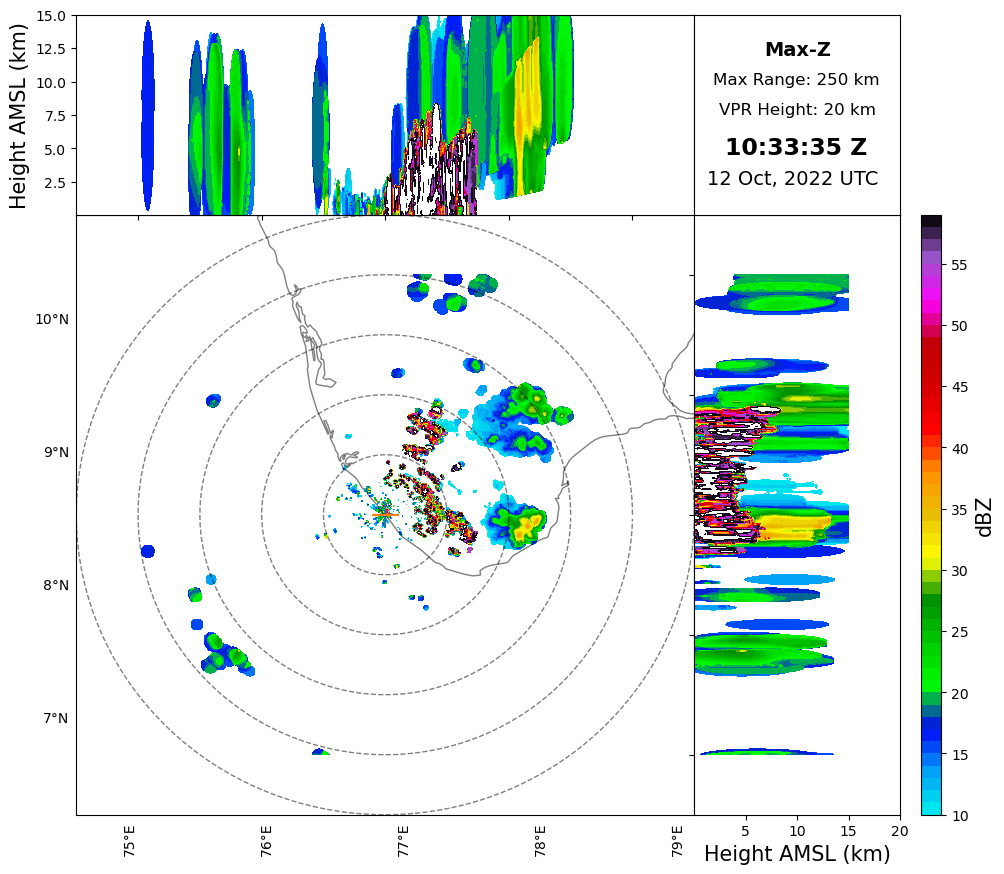

In [21]:
pcf.plot_cappi(grid, "REF")

In [22]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

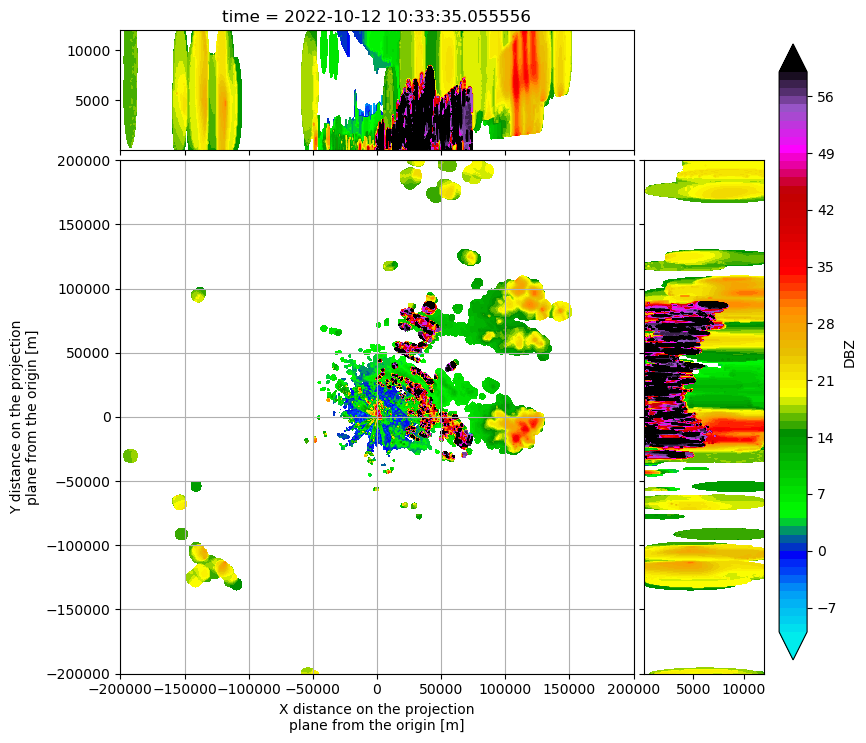

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect(1.)
xgrid['DBZ'][0].max(axis=0).plot.contourf(cmap='pyart_NWSRef',
                                          levels=range(-10,60),
                                          cbar_kwargs={'pad':0.02,
                                                       'shrink':0.8},
                                          ax=ax)
ax.grid()
ax.set_title(None)
# create new axes on the right and on the top of the current axes
divider = make_axes_locatable(ax)
# below height and pad are in inches
ax_x = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
ax_y = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)
# make some labels invisible
ax_x.xaxis.set_tick_params(labelbottom=False)
ax_y.yaxis.set_tick_params(labelleft=False)
xgrid['DBZ'][0].max(axis=1).plot.contourf(cmap='pyart_NWSRef',levels=range(-10,60),add_colorbar=False,ax=ax_x)
xgrid['DBZ'][0].max(axis=2).T.plot.contourf(cmap='pyart_NWSRef',levels=range(-10,60),
                                         add_colorbar=False,add_title=None,ax=ax_y,)
ax_y.set_title(None)
ax_y.set_xlabel(None);ax_y.set_ylabel(None);ax_x.set_xlabel(None);ax_x.set_ylabel(None)
plt.show()

or you can plot at any height (CAPPI)

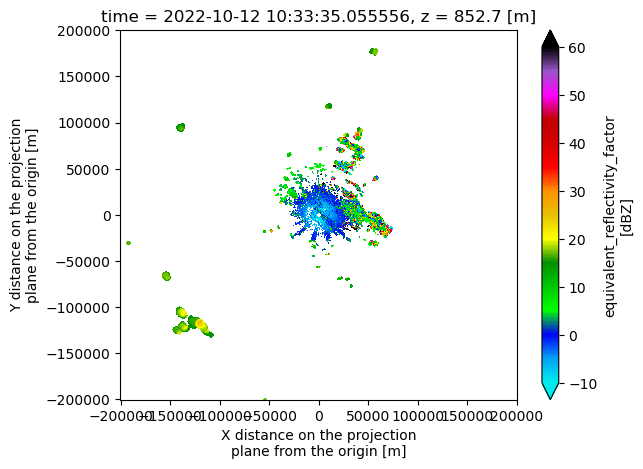

In [14]:
xgrid.DBZ[0].sel(z = 1000, method = "nearest").plot(vmin=-10, vmax = 60, cmap = "pyart_NWSRef") # 1000 is 1km there

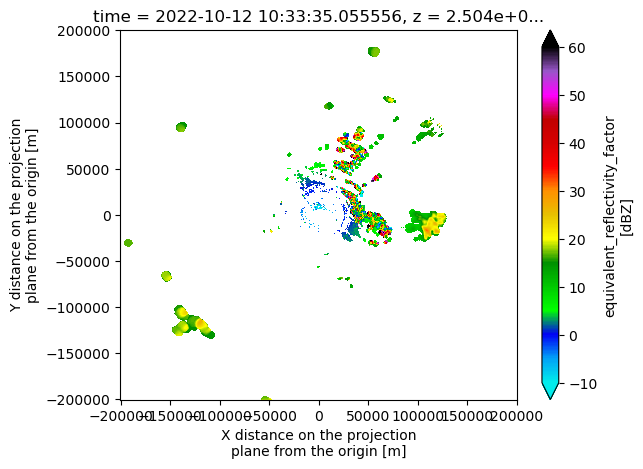

In [15]:
xgrid.DBZ[0].sel(z = 2500, method = "nearest").plot(vmin=-10, vmax = 60, cmap = "pyart_NWSRef") # 1000 is 1km there

In [24]:
import wradlib as wrl

In [49]:
vol = wrl.io.open_cfradial1_dataset("RCTLS_12OCT2022_103335_L2B_STD.nc")
swp_list = []
for v in vol:
     # georeference and stack dimensions
    swp = v.pipe(wrl.georef.georeference_dataset).stack(points=["azimuth", "range"])
    swp_list.append(swp)
# concat sweeps to volume
vol0 = xr.concat(swp_list, dim="points")
# Create XYZ Coordinate DataArray
xyz = xr.concat([vol0.x, vol0.y, vol0.z], dim="xyz").transpose()
# Create Target 3D Grid
trgx = np.linspace(xyz[:, 0].min(),xyz[:, 0].max(), 500)
trgy = np.linspace(xyz[:, 1].min(),xyz[:, 1].max(), 500)
trgz = np.linspace(0, 20000, 100)
yy, hh, xx = np.meshgrid(trgy,trgz,trgx)
trgxyz = np.stack([xx.flatten(), yy.flatten(), hh.flatten()]).T
# Create Gridder/Interpolator
trgshape=xx.shape
gridder = wrl.vpr.CAPPI(polcoords=xyz,
                     gridcoords=trgxyz,
                     gridshape=trgshape,
                     maxrange=200000,
                     minelev=0,
                     maxelev=21,
                     ipclass=wrl.ipol.Nearest)
# Interpolate Data into 3D Grid
crtd_ref = vol0.DBZ#.where(((vol0.RHOHV < 1.0) & (vol0.ZDR>-4) & ((vol0.PHIDP > 150) | (vol0.PHIDP < -150))))
vol_zh = np.ma.masked_invalid(gridder(crtd_ref.values).reshape(trgshape))
trgx = trgxyz[:, 0].reshape(trgshape)[0, 0, :]
trgy = trgxyz[:, 1].reshape(trgshape)[0, :, 0]
trgz = trgxyz[:, 2].reshape(trgshape)[:, 0, 0]

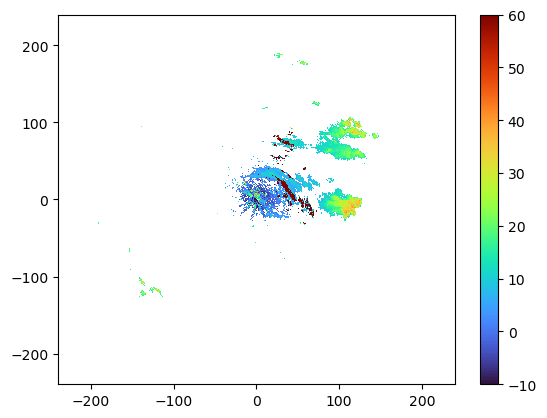

In [51]:
plt.pcolormesh(trgx/1e3, trgy/1e3, vol_zh.max(axis=0), vmin = -10, vmax = 60, cmap="turbo")
plt.colorbar()

In [62]:
from matplotlib import axes
from matplotlib.ticker import NullFormatter
import cartopy.crs as ccrs
import cartopy.feature as feat
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import datetime as dt

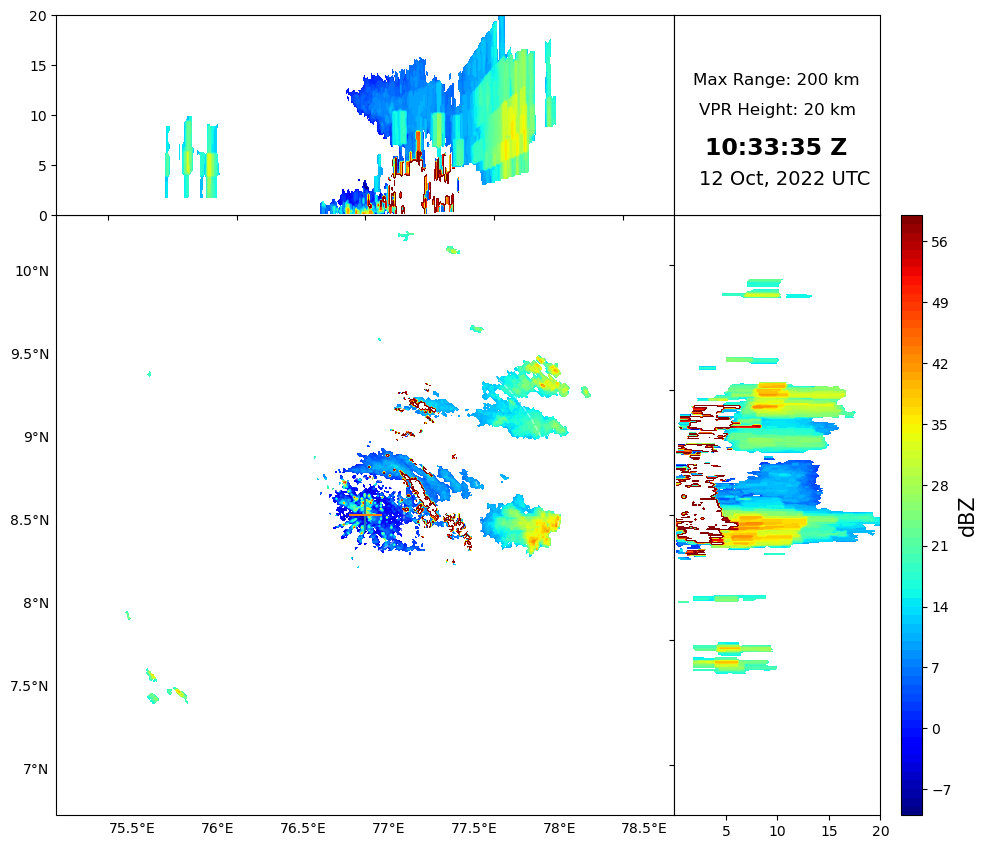

In [65]:
fig = plt.figure(figsize=(10.3,10))
# define axes
left, bottom, width, height = 0.1, 0.1, 0.6, 0.2
left, bottom, width, height = 0.1, 0.1, 0.6, 0.2
ax_xy = plt.axes((left, bottom, width, width),projection=ccrs.LambertAzimuthalEqualArea(v.longitude.values,
                                                                                   v.latitude.values))
ax_x = plt.axes((left, bottom + width, width, height))
ax_y = plt.axes((left + width, bottom, height, width))
ax_cnr = plt.axes((left+width, bottom + width, left+left,height))
ax_cb = plt.axes((left + width + height + 0.02, bottom, 0.02, width))

# set axis label formatters
ax_x.xaxis.set_major_formatter(NullFormatter())
ax_y.yaxis.set_major_formatter(NullFormatter())
ax_cnr.yaxis.set_major_formatter(NullFormatter())
ax_cnr.xaxis.set_major_formatter(NullFormatter())

# # label axes
# ax_xy.set_xlabel("Longitude [°E]",fontsize=15)
# ax_xy.set_ylabel("Latitude [°N]",fontsize=15)
# ax_x.set_xlabel("")
# ax_x.set_ylabel("Height AMSL (km)",fontsize=15)
# ax_y.set_ylabel("")
# ax_y.set_xlabel("Height AMSL (km)",fontsize=15)

# draw CAPPI
plt.sca(ax_xy)
xy = ax_xy.contourf(trgx,trgy,vol_zh.max(axis=0),cmap='jet',levels=range(-10,60))
gl = ax_xy.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, 
                     linestyle='--', draw_labels=True)
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right=False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# gl.xlabel_style = {'weight': 'bold'}
# gl.ylabel_style = {'weight': 'bold'}

[ax_xy.plot(r * np.cos(np.arange(0,360) * np.pi / 180), 
         r * np.sin(np.arange(0,360) * np.pi / 180), 'w--', linewidth=1, alpha=0.5) for r in [25000,75000,125000,
                                                                                              200000]]
ax_xy.set_xlim(-200000,200000)
ax_xy.set_ylim(-200000,200000)
# ax_xy.plot([0,0],[-10000,10000],'-')
# ax_xy.plot([-10000,10000],[0,0],'-')
ax_xy.scatter(0,0, marke)

# draw colorbar
cb = plt.colorbar(xy, cax=ax_cb)
cb.set_label('dBZ',fontsize=15)

plt.sca(ax_x)
plt.contourf(trgx/1e3,trgz/1e3,vol_zh.max(axis=1),cmap='jet',levels=range(-10,70))
# plt.ylim(0,20)
# plt.yticks([0,5,10,15,20])
# plt.grid(axis='y')

plt.sca(ax_y)
plt.contourf(trgz/1e3,trgy/1e3,vol_zh.max(axis=2).T,cmap='jet',levels=range(-10,60))
# plt.xlim(0,20)
ax_y.set_xticks([5,10,15,20])
# plt.grid(axis='x')

plt.sca(ax_cnr)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False,
    labelbottom=False)
# labels along the bottom edge are off
plt.text(0.09,0.65,'Max Range: 200 km',fontsize=12)
plt.text(0.12,0.5,'VPR Height: 20 km',fontsize=12)
plt.text(0.15,0.3,pd.to_datetime(vol[0].time.values).strftime('%H:%M:%S Z'),weight='bold',fontsize=17)
plt.text(0.12,0.15,pd.to_datetime(vol[0].time.values).strftime('%d %b, %Y UTC'),fontsize=14)
ax_xy.set_aspect('auto')
# plt.savefig('plots/'+'Shp_Max-Z_'+str(filename[-29:82])+'.jpg',dpi=200,bbox_inches='tight')